<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/scm_counterfactual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [68]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [0]:
import numpy as np
import torch
from vae_build import VAE, ind_from_att, label_from_dummy
import pyro
import matplotlib.pyplot as plt
from pyro.distributions import OneHotCategorical, RelaxedOneHotCategorical, Normal, Uniform, constraints

In [70]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [71]:
#pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

{'color': OneHotCategorical(), 'shape': OneHotCategorical(), 'scale': OneHotCategorical(), 'orien': OneHotCategorical(), 'posX': OneHotCategorical(), 'posY': OneHotCategorical(), 'latent': Normal(loc: torch.Size([200]), scale: torch.Size([200])), 'img': Uniform(low: torch.Size([4096]), high: torch.Size([4096]))}
tensor([0.9816]) tensor([-0.0148, -0.0100,  1.0109]) tensor([ 0.0117, -0.0175, -0.0096,  0.0020,  1.0078,  0.0084]) tensor([-7.6975e-03, -1.6995e-02, -3.9791e-03,  1.2791e-02, -5.3698e-03,
        -1.2990e-02,  8.4872e-03,  1.4386e-02,  2.1844e-03,  1.6647e-04,
        -1.1868e-02, -2.6624e-03,  9.3540e-03, -9.8858e-03,  1.0163e+00,
        -6.3306e-03,  8.1465e-03,  6.5319e-03, -1.1145e-02, -3.8521e-03,
         9.1430e-04,  1.0012e-02, -3.7997e-03,  1.7066e-02, -1.5598e-02,
         3.1227e-03, -3.7362e-03, -2.4807e-03,  1.2746e-02,  1.4602e-02,
        -4.4828e-04, -1.2261e-02,  5.5984e-03,  1.8430e-02, -1.2327e-02,
        -1.0207e-02, -6.3274e-03,  1.2909e-03,  9.3509e-04,

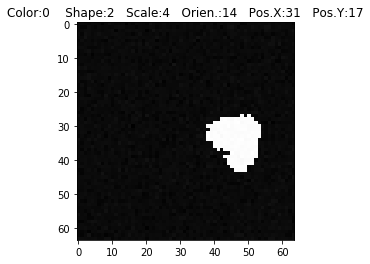

In [130]:
class SCM():
  def __init__(self, vae):
    self.vae = vae
    self.latents_names = ['color', 'shape', 'scale', 'orien', 'posX', 'posY']
    self.latents_sizes = {'color' : 1, 'shape': 3, 'scale':6, 'orien': 40, 'posX': 32, 'posY':32}
    self.init_noise = {'color': OneHotCategorical(torch.tensor([1.])),
                       'shape': OneHotCategorical(torch.tensor([1/3]).repeat(3)),
                       'scale': OneHotCategorical(torch.tensor([1/6]).repeat(6)),
                       'orien': OneHotCategorical(torch.tensor([1/40]).repeat(40)),
                       'posX': OneHotCategorical(torch.tensor([1/32]).repeat(32)),
                       'posY': OneHotCategorical(torch.tensor([1/32]).repeat(32)),
                       'latent': Normal(torch.zeros(200), torch.ones(200)),
                       'img': Uniform(torch.zeros(4096), torch.ones(4096))}
    
    #functions for the model
    def f_gumbel(N):
      return N
    
    def f_posX(N, scale):
      if 31 <= int(scale.max(0)[1] + N.max(0)[1]):
        return torch.nn.functional.one_hot(torch.tensor([31]), 32).to(torch.float32).reshape([32])
      else:
        return torch.nn.functional.one_hot(scale.max(0)[1] + N.max(0)[1], 32).to(torch.float32).reshape([32])

    def f_latent(N_latent, ind, label):
      mu, sigma = vae.encoder.forward(torch.tensor(imgs[ind]).reshape(4096).to(torch.float32), label)
      return N_latent * sigma + mu

    def f_image(N_img, latent, label):
      img_decode = vae.decoder.forward(latent, label)
      return (N_img > img_decode).to(torch.float)

 
    def model(noise = self.init_noise):

      #Noise variables
      N_color = pyro.sample('N_color', noise['color'])
      N_shape = pyro.sample('N_shape', noise['shape'])
      N_scale = pyro.sample('N_scale', noise['scale'])
      N_orien = pyro.sample('N_orien', noise['orien'])
      N_posX = pyro.sample('N_posX', noise['posX'])
      N_posY = pyro.sample('N_posY', noise['posY'])
      N_latent = pyro.sample('N_latent', noise['latent'])
      N_img = pyro.sample('N_img', noise['img'])

      
      print(noise)
      #variables
      color = pyro.sample('color', Normal(f_gumbel(N_color), torch.tensor([0.01])).to_event(1))
      shape = pyro.sample('shape', Normal(f_gumbel(N_shape), torch.tensor([0.01])).to_event(1))
      scale = pyro.sample('scale', Normal(f_gumbel(N_scale), torch.tensor([0.01])).to_event(1))
      orien = pyro.sample('orien', Normal(f_gumbel(N_orien), torch.tensor([0.01])).to_event(1))
      posX = pyro.sample('posX', Normal(f_posX(N_posX, scale), torch.tensor([0.01])).to_event(1))
      posY = pyro.sample('posY', Normal(f_gumbel(N_posY), torch.tensor([0.01])).to_event(1))
      print(color, shape, scale, orien, posX, posY)

      #fixing values to the decoder
      ind = ind_from_att(color.max(0)[1], shape.max(0)[1], scale.max(0)[1], orien.max(0)[1], posX.max(0)[1], posY.max(0)[1])
      label = torch.round(torch.cat([color, shape, scale, orien, posX, posY], -1))
      
      print(label)
      #variables
      latent = pyro.sample('latent', Normal(f_latent(N_latent, ind, label), torch.tensor([0.01])).to_event(1))
      img = pyro.sample('img', Normal(f_image(N_img, latent, label), torch.tensor([0.01])).to_event(1))

      return label, latent, img
    
    def guide(noise):
      #setting noises categorical parameters (probs)
      constr = {'color': constraints.interval(torch.tensor([0.01]), torch.tensor([0.99])),
                'shape': constraints.interval(torch.tensor([0.01]).repeat(3), torch.tensor([0.99]).repeat(3)),
                'scale': constraints.interval(torch.tensor([0.01]).repeat(6), torch.tensor([0.99]).repeat(6)),
                'orien': constraints.interval(torch.tensor([0.01]).repeat(40), torch.tensor([0.99]).repeat(40)),
                'posX': constraints.interval(torch.tensor([0.01]).repeat(32), torch.tensor([0.99]).repeat(32)),
                'posY': constraints.interval(torch.tensor([0.01]).repeat(32), torch.tensor([0.99]).repeat(32)),
                'latent': constraints.interval(torch.tensor([0.01]).repeat(200), torch.tensor([0.99]).repeat(200)),
                'img': constraints.interval(torch.tensor([0.01]).repeat(4096), torch.tensor([0.99]).repeat(4096))}

      noise_param = {'color': pyro.param('prob_color', torch.tensor([1]), constraint = constr['color']),
                    'shape': pyro.param('prob_shape', torch.tensor([1/3]).repeat(3), constraint = constr['shape']),
                    'scale': pyro.param('prob_scale', torch.tensor([1/6]).repeat(6), constraint = constr['scale']),
                    'orien': pyro.param('prob_orien', torch.tensor([1/40]).repeat(40), constraint = constr['orien']),
                    'posX': pyro.param('prob_posX', torch.tensor([1/32]).repeat(32), constraint = constr['posX']),
                    'posY': pyro.param('prob_posY', torch.tensor([1/32]).repeat(32), constraint = constr['posY']),
                    'latent':{'mu': pyro.param('mu_latent', torch.tensor([0.6]).repeat(200), constraint = constr['latent']),
                              'sigma': pyro.param('sigma_latent', torch.tensor([0.8]).repeat(200), constraint = constr['latent'])},
                    'img':{'mu': pyro.param('mu_img', torch.tensor([0.6]).repeat(4096), constraint = constr['img']),
                           'sigma': pyro.param('sigma_img', torch.tensor([0.8]).repeat(4096), constraint = constr['img'])}}

      #categorical samples      
      for key, value in noise_param.items():
        if key != 'latent' and key != 'img':
          print(pyro.sample('N_'+key, RelaxedOneHotCategorical(torch.tensor([0.5]), probs = value)))

      #normal samples
      pyro.sample('N_latent', pyro.distributions.Normal(noise_param['latent']['mu'], noise_param['latent']['mu']))
      pyro.sample('N_img', pyro.distributions.Normal(noise_param['img']['mu'], noise_param['img']['sigma']))
      
      return 
    
    def counterfactual(var_name, obs_var, counter_var, n_steps = 1000):
      #calculating noise posterior in the observation model
      obsModel = pyro.condition(model, data = {var_name : obs_var})
      pyro.clear_param_store()

      #setting the SVI attributes
      adam_params = {'lr': 0.001}
      optmizer = pyro.optim.Adam(adam_params)
      elbo = pyro.infer.Trace_ELBO()
      svi = pyro.infer.SVI(obsModel, guide, optmizer, elbo)

      #training loop
      losses = []
      noise_samples = {latent:[] for latent in self.latents_names}
      noise_samples['latent'] = {'mu':[], 'sigma': []}
      noise_samples['img'] = {'mu':[], 'sigma': []}

      for i in range(n_steps):
        losses.append(svi.step(self.init_noise))
        #saving samples
        for latent in self.latents_names:
          noise_samples[latent].append(pyro.param('prob_'+latent))
        noise_samples['latent']['mu'].append(pyro.param('mu_latent'))
        noise_samples['latent']['sigma'].append(pyro.param('sigma_latent'))
        noise_samples['img']['mu'].append(pyro.param('mu_img'))
        noise_samples['img']['sigma'].append(pyro.param('sigma_img'))

      #calculating means
      mean_values = {latent:[] for latent in self.latents_names}
      mean_values['latent'] = {'mu':[], 'sigma': []}
      mean_values['img'] = {'mu':[], 'sigma': []}
      for latent in self.latents_names:
        mean_values[latent] = torch.mean(torch.stack(noise_samples[latent]), dim = 0)
      mean_values['latent']['mu'] = torch.mean(torch.stack(noise_samples['latent']['mu']), dim = 0)
      mean_values['latent']['sigma'] = torch.mean(torch.stack(noise_samples['latent']['sigma']), dim = 0)
      mean_values['img']['mu'] = torch.mean(torch.stack(noise_samples['img']['mu']), dim = 0)
      mean_values['img']['sigma'] = torch.mean(torch.stack(noise_samples['img']['sigma']), dim = 0)

    
      updated_noise = {}
      for latent in self.latents_names:
        updated_noise[latent] = OneHotCategorical(mean_values[latent])
      updated_noise['latent'] = Normal(mean_values['latent']['mu'], mean_values['latent']['sigma'])
      updated_noise['img'] = Normal(mean_values['img']['mu'], mean_values['img']['sigma'])

      #counterfactual query with updated noise
      intModel = pyro.do(model, data = {var_name : counter_var})
      cf_posterior = pyro.infer.Importance(intModel, guide, n_steps).run(updated_noise)
      cf_marginal = pyro.infer.EmpiricalMarginal(cf_posterior, sites = 'img')
      return cf_marginal.mean

    def viz_model():
      label, _, img = model()
      label = label_from_dummy(label)
      plt.imshow(img.detach().numpy().reshape(64, 64), cmap = 'Greys')
      text = 'Color:0    Shape:'+str(int(label[1])) + '   Scale:' + str(int(label[2])) + '   Orien.:' + str(int(label[3])) + '   Pos.X:' + str(int(label[4])) + '   Pos.Y:' + str(int(label[5]))
      plt.title(text)
      plt.show()

    self.model = model
    self.guide = guide
    self.viz_model = viz_model
    self.counterfactual = counterfactual


scm = SCM(vae)
scm.viz_model()

In [131]:
scm.counterfactual('shape', torch.tensor([1., 0., 0.]), torch.tensor([0., 1., 0.]), n_steps = 1)

tensor([1.], grad_fn=<ExpBackward>)
tensor([0.8255, 0.0118, 0.1627], grad_fn=<ExpBackward>)
tensor([0.3414, 0.0087, 0.4085, 0.0531, 0.1545, 0.0338], grad_fn=<ExpBackward>)
tensor([1.4323e-04, 1.2983e-02, 1.7662e-03, 8.2574e-05, 3.3533e-04, 8.1142e-04,
        4.0066e-05, 1.5624e-04, 1.1983e-01, 1.2451e-01, 1.0773e-04, 4.4222e-03,
        4.9228e-03, 1.5259e-04, 1.7417e-03, 9.2702e-04, 1.4672e-03, 3.7614e-05,
        1.0244e-03, 1.1176e-04, 2.5605e-04, 9.1279e-04, 7.4493e-04, 5.0466e-03,
        3.5068e-02, 1.9017e-03, 1.2294e-04, 6.6201e-01, 1.4288e-03, 4.2986e-04,
        3.7723e-04, 2.2131e-04, 8.0397e-04, 8.4178e-04, 2.2901e-04, 1.9277e-04,
        8.0454e-03, 4.3264e-04, 3.6262e-03, 1.7312e-03], grad_fn=<ExpBackward>)
tensor([1.2827e-03, 2.7777e-04, 1.3634e-02, 9.4184e-05, 1.2341e-03, 1.2225e-03,
        2.8330e-02, 3.3165e-04, 1.4558e-01, 1.1733e-03, 3.8300e-04, 6.7889e-04,
        1.6310e-02, 7.9526e-05, 1.8538e-03, 2.9203e-02, 1.1464e-02, 5.7756e-04,
        1.6103e-04, 2.2419e-

tensor([ 1.0018,  0.9955, -0.0065,  ...,  1.0014,  0.9869, -0.0021])